# Tutorial introduction to PyDEC
Python library for DEC and lowest order FEEC

Anil Hirani and Kaushik Kalyanaraman

---

## Manifold Simplicial Complexes or Meshes

In [1]:
import numpy as np    # Conveniently import a few packages
import matplotlib.pyplot as plt

Let's start by creating a small of a unit square. We will do so by stating the vertex locations in $\mathbb{R}^2$, and the connectivity of these vertices.

Note that connectivity is topological while the embedding is geometric.

In [2]:
# Create a small mesh of square
from pydec import simplicial_complex

vertices = np.array(
       [[-0.5 , -0.5 ],
       [-0.5 ,  0.5 ],
       [-0.04,  0.2 ],
       [ 0.  , -0.5 ],
       [ 0.  ,  0.5 ],
       [ 0.04,  0.2 ],
       [ 0.5 , -0.5 ],
       [ 0.5 ,  0.5 ]])
triangles = np.array([[0, 2, 1],[0, 3, 2],[1, 2, 4],
                      [2, 3, 5],[2, 5, 4],[3, 6, 5],
                      [4, 5, 7],[5, 6, 7]], dtype=int)
sc = simplicial_complex(vertices, triangles)

In the above description of triangles through their contained vertices, the ordering of their verticies is for a consistent orientation.

Next, we draw the mesh that we have constructed above using `matplotlib`

(np.float64(-0.55), np.float64(0.55), np.float64(-0.55), np.float64(0.55))

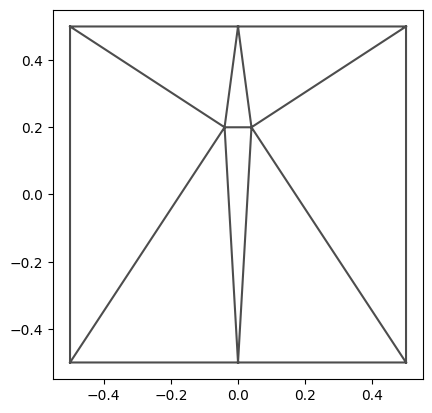

In [3]:
# Draw mesh using matplotlib
import matplotlib.pyplot as plt

plt.triplot(vertices[:, 0], vertices[:, 1], triangles, color=(0.3, 0.3, 0.3))
plt.axis('square')    # Sets the x- and y-scalings to be equal to 

#### On Orientation ####

There is a system for orienting the top dimensional simplices (triangles here) and lower dimensional simplices (edges). These are specified using the vertex ordering.

Meshes can also be loaded from various types of files. Here is an example if using text files included with this tutorial.

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

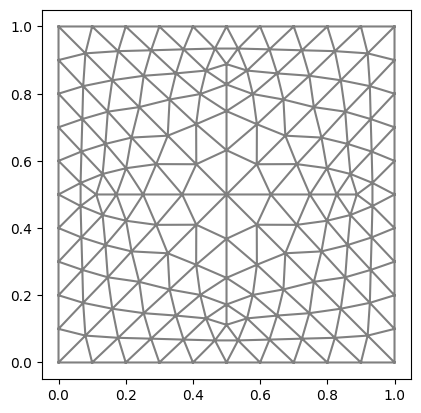

In [4]:
# Load larger mesh of square and display it using Matplotlib
vertices = np.loadtxt('meshes/square272/vertices.txt')
triangles = np.loadtxt('meshes/square272/triangles.txt', dtype=int)
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, color=(0.5, 0.5, 0.5))
plt.axis('square')

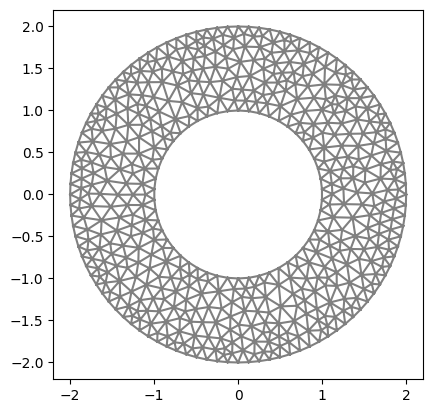

In [5]:
# Load a mesh of an annulus and display it.

vertices = np.loadtxt('meshes/annulus974/vertices.txt')
triangles = np.loadtxt('meshes/annulus974/triangles.txt', dtype=int)
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, color=(0.5, 0.5, 0.5))
plt.axis('square');

---

## Discrete Exterior Derivatives

The discrete exterior derivatives are the coboundary operators. There are two of them for a mesh in two dimensions: $d_0$ and $d_1$. Let's print these for the square with 8 triangles which is reproduced below
![Square figure](square8.pdf)

In [6]:
# d0 and d1

vertices = np.loadtxt('meshes/square8/vertices.txt')
triangles = np.loadtxt('meshes/square8/triangles.txt', dtype=int)
sc = simplicial_complex(vertices, triangles)    # Note that we have already imported simplicial_complex()
d0 = sc[0].d    # Discrete exterior derivative map from 0-cochains to 1-cochains and...
d1 = sc[1].d    # ... from 1-cochains to 2-cochains.

In [7]:
sc

simplicial_complex:
  complex:
            8:  2-simplices
           15:  1-simplices
            8:  0-simplices

In [8]:
d0, d0.todense()

(<15x8 sparse matrix of type '<class 'numpy.int8'>'
 	with 30 stored elements in Compressed Sparse Column format>,
 matrix([[-1,  1,  0,  0,  0,  0,  0,  0],
         [-1,  0,  1,  0,  0,  0,  0,  0],
         [-1,  0,  0,  1,  0,  0,  0,  0],
         [ 0, -1,  1,  0,  0,  0,  0,  0],
         [ 0, -1,  0,  0,  1,  0,  0,  0],
         [ 0,  0, -1,  1,  0,  0,  0,  0],
         [ 0,  0, -1,  0,  1,  0,  0,  0],
         [ 0,  0, -1,  0,  0,  1,  0,  0],
         [ 0,  0,  0, -1,  0,  1,  0,  0],
         [ 0,  0,  0, -1,  0,  0,  1,  0],
         [ 0,  0,  0,  0, -1,  1,  0,  0],
         [ 0,  0,  0,  0, -1,  0,  0,  1],
         [ 0,  0,  0,  0,  0, -1,  1,  0],
         [ 0,  0,  0,  0,  0, -1,  0,  1],
         [ 0,  0,  0,  0,  0,  0, -1,  1]], dtype=int8))

In [9]:
d1, d1.todense()

(<8x15 sparse matrix of type '<class 'numpy.int8'>'
 	with 24 stored elements in Compressed Sparse Column format>,
 matrix([[-1,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, -1,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  1,  0, -1,  1,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0, -1,  1,  0,  0, -1,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0, -1,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  1,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  1]],
        dtype=int8))

We verify the complex property: $d_1 \circ d_0 = 0$ using matrix multiplication.

In [10]:
# We verify the complex property

print((d1*d0).todense())

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


## Hodge star

The DEC Hodge star matrices are diagonal matrices with all positive entries. The values are dual over primal measure. There is one matrix for each dimension (0, 1, 2) in case of a 2-dimensional manifold complex.

On a simplicial complex $X$ with dimension $n$, the Hodge star $\star_k$ acting on a $k$-cochain on the primal mesh produces an $(n - k)$-cochain on the dual mesh. However, we note that PyDEC does not save an explicit representation of the dual cell complex. $\star_k$ is then a diagonal matrix of size $N_k \times N_k$ where $N_k$ is the dimension of $C^k$, the (vector) space of primal $k$-cochains. It's $i^{\text{th}}$ diagonal entry is given by:
$$
(\star_k)_i = \dfrac{\vert {\star \sigma_i^k} \vert}{\vert {\sigma_i^k} \vert},
$$
where $\sigma_i^k$ is the $k$-simplex in $X$ with index $i$ and $\star \sigma_i^k$ is its geomtric dual which would be a $(n - k)$-cell. The $\vert \cdot \vert$ denotes volumes, and so the Hodge star entries are ratios of volumes of the dual entities over their corresponing primal ones. 

As a final note, the geometric duality in DEC is based on circumcenters yielding the above nice formula for the Hodge stars. Other definitions of a dual mesh are possible, for example, barycentric duals but we do not concern ourselves with those and the Hodge stars are not diagonal matrices over such primal-dual meshes.

We shall now try to get a sense of this over the earlier small mesh.

(np.float64(-1.7), np.float64(2.7), np.float64(-0.1), np.float64(2.1))

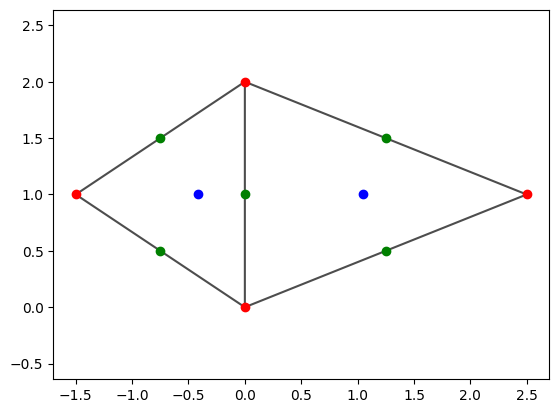

In [11]:
vertices = np.array(
       [[0, 0],
       [0, 2],
       [2.5,  1],
       [-1.5, 1]])
triangles = np.array([[0, 2, 1],[0, 1, 3]], dtype=int)
sc = simplicial_complex(vertices, triangles)
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, color=(0.3, 0.3, 0.3))

# We visualize the circumcenters of the various primal simplices and
# these are readily available in PyDEC
plt.plot(sc[0].circumcenter[:, 0], sc[0].circumcenter[:, 1], 'ro')
plt.plot(sc[1].circumcenter[:, 0], sc[1].circumcenter[:, 1], 'go')
plt.plot(sc[2].circumcenter[:, 0], sc[2].circumcenter[:, 1], 'bo')
plt.axis('equal')    # Sometimes we need to set axis "equal". Feel free to look up the documentation of Matplotlib for differences.

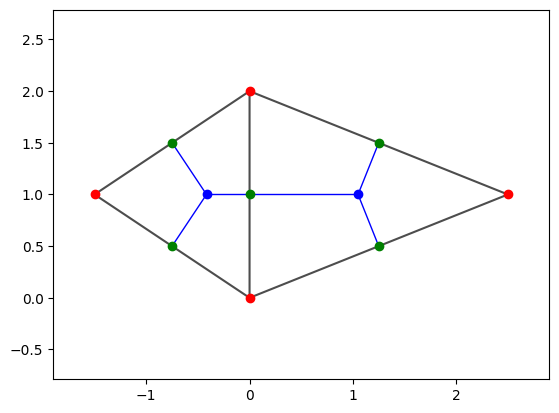

In [12]:
# We shall now visualize the dual edges.
# The following code snippet is by Anil Hirani and is a careful way to draw the 
# dual mesh which PyDEC does not explicitly represent. We shall skip discussion
# of this code fragment and we do nicely package it into visualizable classes 
# which would be public as part of PyDEC in a near future!

plt.triplot(vertices[:, 0], vertices[:, 1], triangles, color=(0.3, 0.3, 0.3))
plt.axis('equal')
plt.plot(sc[0].circumcenter[:, 0], sc[0].circumcenter[:, 1], 'ro')
plt.plot(sc[1].circumcenter[:, 0], sc[1].circumcenter[:, 1], 'go')
plt.plot(sc[2].circumcenter[:, 0], sc[2].circumcenter[:, 1], 'bo')

from itertools import combinations
from pydec import Simplex
from matplotlib.collections import PolyCollection, LineCollection

dual_lines = set(); remove_dual_lines = set()
for s_index, simplex in enumerate(sc.simplices):
    cc_simplex = sc[2].circumcenter[s_index]
    cc_simplex_bary = sc[2].bary_circumcenter[s_index]
    cc_simplex_bary_signs = [0, 0, 0]
    for i in range(3):
        if abs(cc_simplex_bary[i]) < 1e-12:
            cc_simplex_bary_signs[i] = 0
        else:
            cc_simplex_bary_signs[i] = int(np.sign(cc_simplex_bary[i]))

    edges = [edge for edge in combinations(np.sort(simplex), 2)]
    local_opp_vertex = [2, 1, 0]
    edge_indices = [sc[1].simplex_to_index[Simplex(edge)] for edge in edges]
    cc_edges = [sc[1].circumcenter[e_index] for e_index in edge_indices]
    for e_index, cc_edge in enumerate(cc_edges):
        cc_edge = tuple(cc_edge)
        cc_simplex = tuple(cc_simplex)
        # Add every half dual edge in a triangle
        dual_lines.add((cc_edge, cc_simplex))

        # However, if the circumcenter is outside the triangles, need to modify the
        # addition of the half dual edge for visualization in accordance with sign
        # convention for DEC. Thus, for a circumcenter lying outside a triangle,
        # remove the half dual edges to the common edge of the triangle and from its
        # neighbor where the circumcenter lies. Finish by introducing the dual edge
        # between the circumcenters of these two triangles.
        cc_oppvrtx_sign = cc_simplex_bary_signs[local_opp_vertex[e_index]]
        if cc_oppvrtx_sign <= 0:
            curr_edge_index = edge_indices[e_index]
            opp_s_index = (set(sc[1].d.getcol(curr_edge_index).indices) - {s_index})
            if len(opp_s_index) != 0:
                opp_s_index = opp_s_index.pop()
                opp_cc_simplex = sc[2].circumcenter[opp_s_index]                        
                opp_cc_simplex = tuple(opp_cc_simplex)
                dual_lines.add((cc_simplex,opp_cc_simplex))
                remove_dual_lines.add((cc_edge, cc_simplex))
                # There is still a catch! The triangle could be right angled and have the
                # circumcenter on its hypotenuse. Then, have to factor this degeneracy of
                # half dual edges while building the visualization.
                if cc_oppvrtx_sign < 0:
                    remove_dual_lines.add((cc_edge, opp_cc_simplex))
                else:
                    # For a right angled triangle, do not remove the edge center to
                    # circumcenter dual line since it does not exist.
                    pass

dual_lines -= remove_dual_lines
dual_lines = list(dual_lines)
col = LineCollection(dual_lines, zorder=1)
col.set_linewidth(1)
col.set_alpha(1)
col.set_edgecolor((0, 0, 1))
ax = plt.gca()
ax.set_facecolor('none')
ax.add_collection(col, autolim=True)
ax.autoscale_view()
ax.set_aspect('equal')
xmin, ymin, xmax, ymax = ax.dataLim.extents
ax.set_xlim((xmin - (xmax-xmin)*.1, xmax + (xmax-xmin)*.1))
ax.set_ylim((ymin - (ymax-ymin)*.1, ymax + (ymax-ymin)*.1));

We shall now examine the primal and dual volumes of the various simplices

In [13]:
print("The simplicial complex is")
print(sc)

The simplicial complex is
simplicial_complex:
  complex:
            2:  2-simplices
            5:  1-simplices
            4:  0-simplices



In [14]:
# Print the primal volumes
print("The primal Volumes in 0-, 1- and 2-dimensions are as below.")
print("O-dimensions: ", sc[0].primal_volume, ",")
print("1-dimensions: ", sc[1].primal_volume, ", and")
print("2-dimensions: ", sc[2].primal_volume, ".")

The primal Volumes in 0-, 1- and 2-dimensions are as below.
O-dimensions:  [1. 1. 1. 1.] ,
1-dimensions:  [2.         2.6925824  1.80277564 2.6925824  1.80277564] , and
2-dimensions:  [2.5 1.5] .


In [15]:
# Print the dual volumes
print("The dual Volumes in 0-, 1- and 2-dimensions are as below.")
print("O-dimensions: ", sc[0].dual_volume, ",")
print("1-dimensions: ", sc[1].dual_volume, ", and")
print("2-dimensions: ", sc[2].dual_volume, ".")

The dual Volumes in 0-, 1- and 2-dimensions are as below.
O-dimensions:  [1.36666667 1.36666667 0.725      0.54166667] ,
1-dimensions:  [1.46666667 0.53851648 0.60092521 0.53851648 0.60092521] , and
2-dimensions:  [1. 1.] .


In [16]:
# Finally, print the Hodge star matrices
print("The Hodge stars acting on 0-, 1- and 2-cochain are next.")
print("0-Hodge star is of size", sc[0].star.shape, " with entries:\n", sc[0].star.todense())

The Hodge stars acting on 0-, 1- and 2-cochain are next.
0-Hodge star is of size (4, 4)  with entries:
 [[1.36666667 0.         0.         0.        ]
 [0.         1.36666667 0.         0.        ]
 [0.         0.         0.725      0.        ]
 [0.         0.         0.         0.54166667]]


In [17]:
print("1-Hodge star is of size", sc[1].star.shape, " with entries:\n", sc[1].star.todense())

1-Hodge star is of size (5, 5)  with entries:
 [[0.73333333 0.         0.         0.         0.        ]
 [0.         0.2        0.         0.         0.        ]
 [0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.2        0.        ]
 [0.         0.         0.         0.         0.33333333]]


In [18]:
print("2-Hodge star is of size", sc[2].star.shape, " with entries:\n", sc[2].star.todense())

2-Hodge star is of size (2, 2)  with entries:
 [[0.4        0.        ]
 [0.         0.66666667]]


---

## PDEs with Hodge-Laplacian

Now we will solve two different PDEs with Hodge-Laplace operator. This can be done in mixed or standard forms.

### Hodge-Laplace Poisson Problem on $0$-forms 

$\Delta_0 u = f$ on $M$ with $*d u = 0$ on $\partial M$ and $u \perp$ harmonic 0-forms.

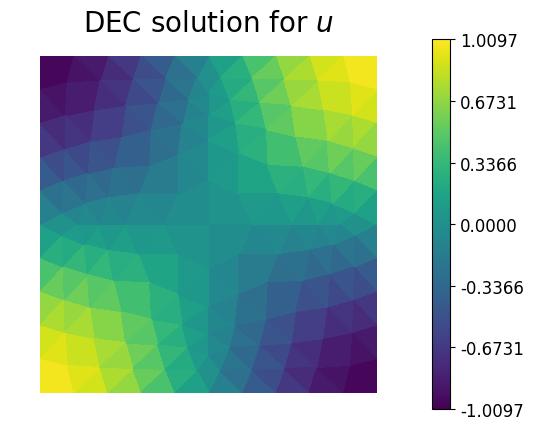

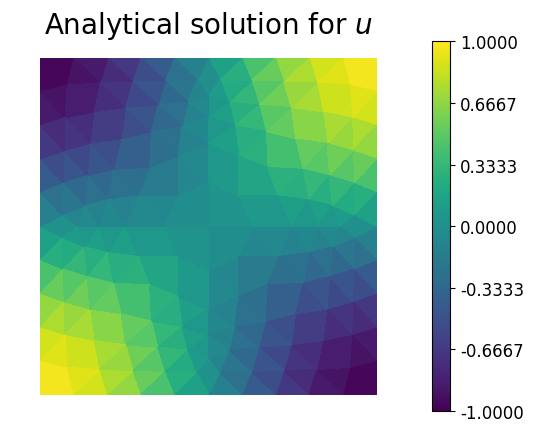

In [19]:
import scipy.sparse as sprs
import scipy.sparse.linalg as spla

# We first need a known solution and the corresponding right hand side function
def u_analytical(x, y):
    return np.cos(np.pi*x) * np.cos(np.pi*y)

def f(x, y):
    return 2 * np.pi**2 * np.cos(np.pi*x) * np.cos(np.pi*y)

# We shall solve this problem on the unit square from above
vertices = np.loadtxt('meshes/square272/vertices.txt')
triangles = np.loadtxt('meshes/square272/triangles.txt', dtype=np.int64)

# We first set up an instance of the simplicial_complex class
sc = simplicial_complex(vertices, triangles)

# We now set up the discretized Laplacian and right hand side
N0 = sc[0].num_simplices    # Number of vertices
d0 = sc[0].d    # The d0 matrix
hodge0 = sc[0].star    # Hodge star 0
hodge1 = sc[1].star    # Hodge star 1
A = d0.T * hodge1 * d0    # Stiffness matrix corresponding to the system
b = np.zeros(N0)    # Initial right hand side...
u = np.zeros(N0)    # and solution vectors
b = np.array([f(*v) for v in sc.vertices])    # Compute the discretized right hand side

C = np.asmatrix(np.ones(N0))    # Constraint matrix for u orthogonal to harmonics
K = sprs.bmat([[A, C.T],
               [C, None]], format='csr')
rhs = np.hstack((hodge0 * b, [0]))    # Solve constrainted linear system using Lagrange multipliers
x = spla.spsolve(K, rhs)    # Solution using a sparse direct solvers
u = x[:N0]    # Extract the solution...
lmbda = x[N0]    # and ignore the Lagrange multiplier

# Visualize
u_true = np.array([u_analytical(*v) for v in sc.vertices])
plt.figure(); ax = plt.gca()
plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, u, vmin=min(u), vmax=max(u))
cb = plt.colorbar(ticks=np.linspace(min(u), max(u), 7), format='%1.4f')
plt.axes(cb.ax);
plt.yticks(fontsize=12); plt.axes(ax)
ax.set_title("DEC solution for $u$", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

plt.figure(); ax = plt.gca()
plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, u_true, vmin=min(u_true), vmax=max(u_true))
cb = plt.colorbar(ticks=np.linspace(min(u_true), max(u_true), 7), format='%1.4f')
plt.axes(cb.ax);
plt.yticks(fontsize=12); plt.axes(ax)
ax.set_title("Analytical solution for $u$", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

### Hodge-Laplace Helmholtz problem on $1$-forms 

Hodge-Laplace Helmholtz problem on $1$-forms: $\Delta_1 u = \lambda u$ on $M$ with $*u = 0$, $* d u = 0$ on $\partial M$.

Computed eigenvalues are:  [-2.39912257e-15  4.60036850e-01  4.60089079e-01  1.79669985e+00
  1.79707573e+00  3.89624420e+00]


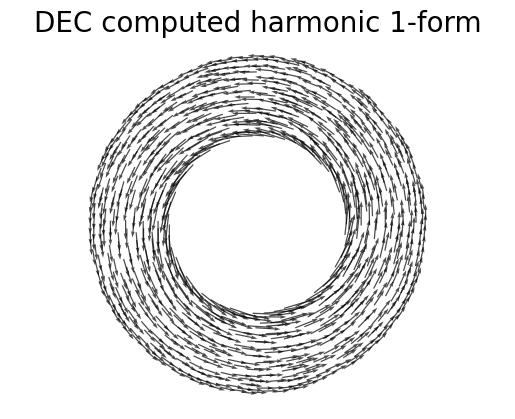

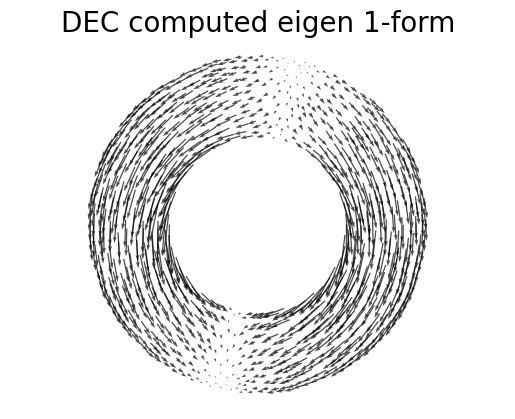

In [20]:
import numpy.linalg as npla
from pydec import simplex_quivers

# We shall solve this problem on the annulus domain as earlier
vertices = np.loadtxt('meshes/annulus974/vertices.txt')
triangles = np.loadtxt('meshes/annulus974/triangles.txt', dtype=int)

# Setup and solve
sc = simplicial_complex(vertices, triangles)

# Obtain the discrete exterior derivative matrices
d0 = sc[0].d
d1 = sc[1].d

# The count of the number of vertices and edges
N0 = sc[0].num_simplices
N1 = sc[1].num_simplices

# The DEC Hodge stars
hodge0 = sc[0].star
hodge1 = sc[1].star
hodge2 = sc[2].star

# Setup the matrices for the generalized Hodge Laplacian Helmholtz problem
A = sprs.bmat([[hodge0, -d0.T * hodge1],
               [hodge1 * d0, d1.T * hodge2 * d1]], format='csr')
B = sprs.bmat([[sprs.csr_matrix((N0, N0)), None], 
               [None, hodge1]], format='csr')

# Compute the eigenvalues and eigenvectors using a sparse eigensolver.
# We are trying to obtain the smallest magnitude {eigenvalues, eigenvectors} using shifts
evals, evectors = spla.eigsh(A=A, k=6, M=B, sigma=0.01)
print("Computed eigenvalues are: ", evals)

# (Note: Eigenvectors are stored column wise, e.g., the first eigenvector is in the first column in evectors.)

# Obtain the u component of the eigenvectors
u_evectors = evectors[N0:, :]
# Normalize eigenvectors for "nicer" plots (remember this is still an eigenvector)
for i in range(evectors.shape[1]):
    u_evectors[:, i] /= npla.norm(u_evectors[:, i])

# Visualize the eigenvectors corresponding to the smallest and second smallest magnitude eigenvalues.
# PyDEC in-built function to interpolate a 1-cochain to a Whitney 1-form, and sample it at the simplex barycenters
bases, arrows1 = simplex_quivers(sc, u_evectors[:, 0])

plt.figure(); ax = plt.gca()
custom_quiver = {'color': 'k', 'alpha': 0.7, 'scale': 1, 'scale_units': 'xy', 'width': 0.0025}
ax.quiver(bases[:, 0], bases[:, 1], arrows1[:, 0], arrows1[:, 1],**custom_quiver)
ax.set_title("DEC computed harmonic 1-form", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

# The eigenvector corresponding to the second nonzero eigenvalue
bases, arrows2 = simplex_quivers(sc, u_evectors[:, 1])

plt.figure(); ax = plt.gca()
ax.quiver(bases[:, 0], bases[:, 1], arrows2[:, 0], arrows2[:, 1],**custom_quiver)
ax.set_title("DEC computed eigen 1-form", fontsize=20)
plt.axis('equal'); ax.set_axis_off()


### Hodge-Laplace Poisson problem on $1$-forms

#### Hodge-Laplace Helmholtz problem on $1$-forms

PDE in Primal/Strong Form:
$$
\Delta_1 u = f \text{~on~} M \text{~with~} *u = 0, * d u = 0 \text{~on~} \partial M \text{~and~} u \perp \text{harmonic~} 1\text{-forms}.
$$

PDE in Mixed Form: 
\begin{align}
\sigma &= \delta u,\\
d \sigma + \delta d u &= f \text{~on~} M, \\
\text{with~} *u = 0, * d u = 0 \text{~on~} \partial M, &
\text{~and~} u \perp \text{harmonic~} 1\text{-forms}.
\end{align}



In [21]:
# We shall use the above stated mixed formulation and its discretization to solve this problem

# Analytical solutions for u and sigma
def u_analytical(r, th, R0=1, R1=2):
    u_r =  (r - R0) * (r - R1)
    u_th = 0
    return np.array([u_r, u_th])

def sigma_analytical(r, th, R0=1, R1=2):
    return -((r - R0) * (r - R1) + r * (2*r - R0 - R1))/r

# Exterior derviatives and codifferentials of these solutions
def du_analytical(r, th, R0=1, R1=2):
    return 0

def delta_du_analytical(r, th, R0=1, R1=2):
    dsdu_r = 0
    dsdu_th = 0
    return np.array([dsdu_r, dsdu_th])

def d_sigma_analytical(r, th, R0=1, R1=2):
    ds_r = (-(3*r * (2*r - R0 - R1) + 2*r**2 -
             (r - R0) * (r - R1))/r**2)
    ds_th = 0
    return np.array([ds_r, ds_th])

# Analytical harmonic on this annulus
def h_analytical(r, th):
    h_r = 0
    h_th = 1
    return np.array([h_r, h_th])

def f_analytical(r, th, R0=1, R1=2):
    return (delta_du_analytical(r, th) +
            d_sigma_analytical(r, th))

# Some helper functions since we use polar coordinates in this computation
def cart2pol(x, y):
    return (np.sqrt(x**2 + y**2), np.arctan2(y, x))

def J_cart2pol(r, th):
    # Jacobian for cartesian to polar transformation
    # Note: J_cart2pol = inv(J_pol2cart) = J_pol2cart.T
    ## return np.array(
    ##     [[np.cos(th), np.sin(th)],
    ##      [-r*np.sin(th), r*np.cos(th)]])
    return np.array(
        [[np.cos(th), -r * np.sin(th)],
         [np.sin(th), r * np.cos(th)]])

def J_pol2cart(r, th):
    # Jacobian for polar to cartesian transformation
    # Note: J_pol2cart = inv(J_cart2pol) = J_cart2pol.T
    ## return np.array(
    ##     [[np.cos(th), -np.sin(th)/r],
    ##      [np.sin(th), np.cos(th)/r]])
    return np.array(
        [[np.cos(th), np.sin(th)],
         [-np.sin(th)/r, np.cos(th)/r]])

# We shall interpolate u with Whitney 1-forms and sigma using Lagrange elements 
# which we think of as Whitney 0-forms
def whitney_zero_form(u, x, y, vertices):
    """ Compute the smooth zero-form from a zero-cochain using
    lowest-order Lagrange interpolation. 
    
    """
    x0, x1, x2 = vertices.T[0]
    y0, y1, y2 = vertices.T[1]
    mu = npla.solve(np.array([[x0, x1, x2],
                              [y0, y1, y2],
                              [1., 1., 1.]]),
                              np.array([x, y, 1.]))
    return sum([mu[i] * u[i] for i in xrange(3)])

def whitney_one_form(u, x, y, vertices):
    """ Compute the smooth one-form from a one-chain using
    Whitney interpolation.
    
    """
    x0, x1, x2 = vertices.T[0]
    y0, y1, y2 = vertices.T[1]
    mu = npla.solve(np.array([[x0, x1, x2],
                              [y0, y1, y2],
                              [1, 1, 1]]),
                              np.array([x, y, 1]))
    d_mu = barycentric_gradients(vertices)
    return (u[0] * (mu[0] * d_mu[1] - mu[1] * d_mu[0]) +
            u[1] * (mu[0] * d_mu[2] - mu[2] * d_mu[0]) +
            u[2] * (mu[1] * d_mu[2] - mu[2] * d_mu[1]))


In [22]:
# Now we move on to setting up the problem and its solution
import scipy.integrate as spint
import scipy.sparse as sprs
import scipy.sparse.linalg as spla

# Load the mesh of the annulus 
vertices = np.loadtxt('meshes/annulus974/vertices.txt')
triangles = np.loadtxt('meshes/annulus974/triangles.txt', dtype=int)

# Set up the simplicial complex, operators and mixed formuation
sc = simplicial_complex(vertices, triangles)
d0 = sc.cochain_complex()[0]; d1 = sc.cochain_complex()[1]
N0 = sc[0].num_simplices; N1 = sc[1].num_simplices
N2 = sc[2].num_simplices
hodge0 = sc[0].star
hodge1 = sc[1].star
hodge2 = sc[2].star

# Mixed formulation discretization matrix of the 1-Hodge Laplacian
A = sprs.bmat([[-hodge0, d0.T * hodge1],
               [hodge1 * d0, d1.T * hodge2 * d1]],
               format='csr')

# Next, we compute the right hand side for this linear system from given f
# Also, we determine the projection of the smooth solution and 1-harmonic form to 1-cochains
f = np.zeros(N1); harmonic = np.zeros(N1)
u_true = np.zeros(N1); d_u_true = np.zeros(N2)
f_alt = np.zeros(N1)
for i, e in enumerate(sc[1].simplices):
    evector = vertices[e[1]] - vertices[e[0]]
    unit_tangent = evector / npla.norm(evector)
    def f_dot_t(t):
        r_t, ph_t = cart2pol(*(vertices[e[0]] + t * evector))
        J = J_pol2cart(r_t, ph_t)
        return (np.dot(unit_tangent,
                np.dot(J.T, f_analytical(r_t, ph_t))) *
                npla.norm(evector))
    def h_dot_t(t):
        r_t, ph_t = cart2pol(*(vertices[e[0]] + t * evector))
        J = J_pol2cart(r_t, ph_t)
        return (np.dot(unit_tangent,
                np.dot(J.T, h_analytical(r_t, ph_t))) *
                npla.norm(evector))
    f[i] = spint.quad(f_dot_t, 0, 1,
                      epsabs=1e-15, epsrel=1e-12)[0]
    harmonic[i] = spint.quad(h_dot_t, 0, 1,
                             epsabs=1e-15, epsrel=1e-12)[0]
b = np.hstack((np.zeros(N0), hodge1 * f))

# Finally, we solve the constrainted linear problem with u being orthogonal 
# to the space of harmonics using Lagrange multipliers
# C = sprs.csr_matrix([np.hstack((np.zeros((1, N0)), hodge1 * harmonic))])
C = sprs.csr_matrix([np.hstack((np.zeros(N0), hodge1 * harmonic))])
K = sprs.bmat([[A, C.T],
               [C, None]], format='csr')
rhs = np.hstack((b, [0]))
x = spla.spsolve(K, rhs)

# Extract sigma and u from this solution
sigma = x[:N0]; u = x[N0:-1]

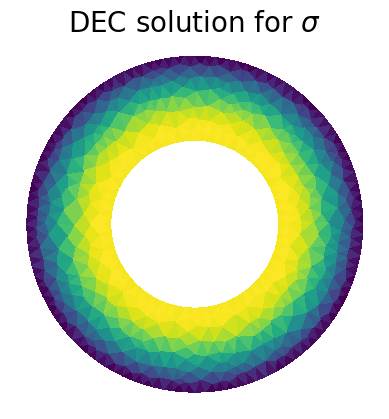

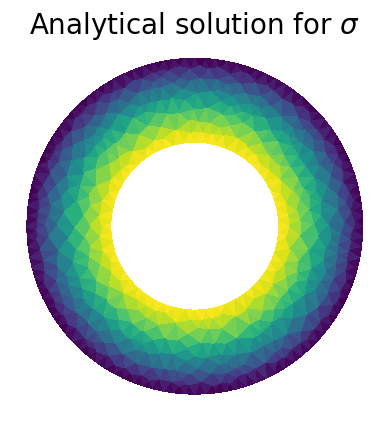

In [23]:
# Visualize the solutions: sigma

# Plot computed 0-form sigma
plt.figure(); fig = plt.gcf(); ax = plt.gca()
ax.tripcolor(sc.vertices[:, 0], sc.vertices[:, 1], sc.simplices, sigma)
ax.set_aspect('equal'); plt.axis('off')
ax.set_title('DEC solution for $\sigma$', fontsize=20);

# Plot true 0-form sigma
sigma_true = np.array(list(map(lambda x: sigma_analytical(*cart2pol(*x)), sc.vertices)))

plt.figure(); fig = plt.gcf(); ax = plt.gca()
ax.tripcolor(sc.vertices[:, 0], sc.vertices[:, 1], sc.simplices, sigma_true)
ax.set_aspect('equal'); plt.axis('off')
ax.set_title('Analytical solution for $\sigma$', fontsize=20);

Text(0.5, 1.0, 'Smooth solution for $u$')

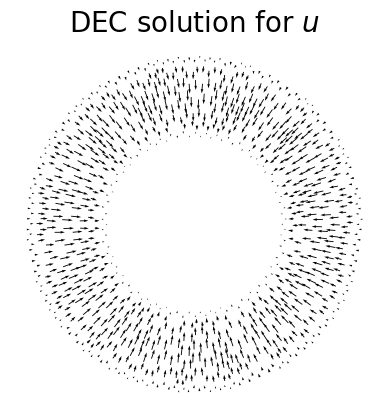

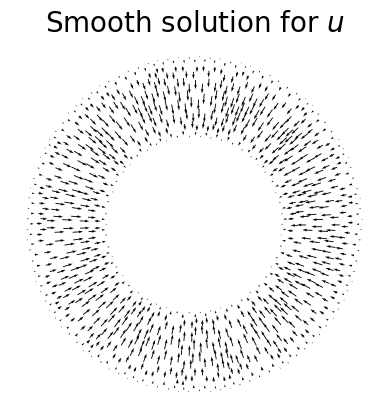

In [25]:
# Visualize the solutions: u

# Plot computed 1-form u via the proxy vector field
plt.figure(); fig = plt.gcf(); ax = plt.gca()
u_bases, u_arrows = simplex_quivers(sc, u)
ax.quiver(u_bases[:, 0], u_bases[:, 1],
          u_arrows[:, 0], u_arrows[:, 1],
          units='dots', color='k')
ax.set_aspect('equal'); plt.axis('off')
ax.set_title("DEC solution for $u$", fontsize=20);

# Plot true 1-form u via the proxy vector field
plt.figure(); fig = plt.gcf(); ax = plt.gca()
u_true_arrows = np.array(list(map(
    lambda x: np.dot(J_pol2cart(*cart2pol(*x)).T,
                     u_analytical(*cart2pol(*x))), u_bases)))
ax.quiver(u_bases[:, 0], u_bases[:, 1],
          u_true_arrows[:, 0], u_true_arrows[:, 1],
          units='dots', color='k')
ax.set_aspect('equal'); plt.axis('off')
ax.set_title("Smooth solution for $u$", fontsize=20)


---

## Connection with finite element exterior calculus

By replacing the diagonal DEC mass matrices with lowest order FEEC mass matrices the above setup becomes a finite element method.

In [ ]:
# FEEC version of Hodge-Laplace problem on 0-forms

In [ ]:
# See the earlier code for more comments about the various sections

from pydec import simplicial_complex, whitney_innerproduct
import scipy.sparse as sprs
import scipy.sparse.linalg as spla

# Define the analytical solution and right hand side function
def u_analytical(x, y):
    return np.cos(np.pi*x) * np.cos(np.pi*y)

def f(x, y):
    return 2 * np.pi**2 * np.cos(np.pi*x) * np.cos(np.pi*y)

# Read the mesh
vertices = np.loadtxt('meshes/square272/vertices.txt')
triangles = np.loadtxt('meshes/square272/triangles.txt', dtype=np.int64)
sc = simplicial_complex(vertices, triangles)

# Set up the discretized Laplacian and right hand side
N0 = sc[0].num_simplices    # Number of vertices
d0 = sc[0].d    # The d0 matrix
hodge0 = whitney_innerproduct(sc, 0)    # FEEC mass matrix for 0-forms in the polynomial subspace
hodge1 = whitney_innerproduct(sc, 1)    # FEEC mass matrix for 1-forms in the polynomial subspace
A = d0.T * hodge1 * d0    # Stiffness matrix corresponding to the system
b = np.zeros(N0)    # Initial right hand side...
u = np.zeros(N0)    # and solution vectors
b = np.array([f(*v) for v in sc.vertices])    # Compute the discretized right hand side

C = np.asmatrix(np.ones(N0))    # Constraint matrix for u orthogonal to harmonics
K = sprs.bmat([[A, C.T],
               [C, None]], format='csr')
rhs = np.hstack((hodge0 * b, [0]))    # Solve constrainted linear system using Lagrange multipliers
x = spla.spsolve(K, rhs)    # Solution using a sparse direct solvers
u = x[:N0]    # Extract the solution...
lmbda = x[N0]    # and ignore the Lagrange multiplier

# Visualize
u_true = np.array([u_analytical(*v) for v in sc.vertices])
plt.figure(); ax = plt.gca()
plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, u, vmin=min(u), vmax=max(u))
cb = plt.colorbar(ticks=np.linspace(min(u), max(u), 7), format='%1.4f')
plt.axes(cb.ax);
plt.yticks(fontsize=12); plt.axes(ax)
ax.set_title("FEEC solution for $u$", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

plt.figure(); ax = plt.gca()
plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, u_true, vmin=min(u_true), vmax=max(u_true))
cb = plt.colorbar(ticks=np.linspace(min(u_true), max(u_true), 7), format='%1.4f')
plt.axes(cb.ax);
plt.yticks(fontsize=12); plt.axes(ax)
ax.set_title("Analytical solution for $u$", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

In [ ]:
# FEEC version of Helmholtz problem on 1-forms

In [ ]:
import numpy.linalg as npla
from pydec import simplex_quivers, whitney_innerproduct

# We shall solve this problem on the annulus domain as earlier
vertices = np.loadtxt('meshes/annulus974/vertices.txt')
triangles = np.loadtxt('meshes/annulus974/triangles.txt', dtype=int)

# Setup and solve
sc = simplicial_complex(vertices, triangles)

# Obtain the discrete exterior derivative matrices
d0 = sc[0].d
d1 = sc[1].d

# The count of the number of vertices and edges
N0 = sc[0].num_simplices
N1 = sc[1].num_simplices

# The DEC Hodge stars
hodge0 = whitney_innerproduct(sc, 0)
hodge1 = whitney_innerproduct(sc, 1)
hodge2 = whitney_innerproduct(sc, 2)

# Setup the matrices for the generalized Hodge Laplacian Helmholtz problem
A = sprs.bmat([[hodge0, -d0.T * hodge1],
               [hodge1 * d0, d1.T * hodge2 * d1]], format='csr')
B = sprs.bmat([[sprs.csr_matrix((N0, N0)), None], 
               [None, hodge1]], format='csr')

# Compute the eigenvalues and eigenvectors using a sparse eigensolver.
# We are trying to obtain the smallest magnitude {eigenvalues, eigenvectors} using shifts
evals, evectors = spla.eigsh(A=A, k=6, M=B, sigma=0.01)
print("Computed eigenvalues are: ", evals)

# (Note: Eigenvectors are stored column wise, e.g., the first eigenvector is in the first column in evectors.)

# Obtain the u component of the eigenvectors
u_evectors = evectors[N0:, :]
# Normalize eigenvectors for "nicer" plots (remember this is still an eigenvector)
for i in range(evectors.shape[1]):
    u_evectors[:, i] /= npla.norm(u_evectors[:, i])

# Visualize the eigenvectors corresponding to the smallest and second smallest magnitude eigenvalues.
# PyDEC in-built function to interpolate a 1-cochain to a Whitney 1-form, and sample it at the simplex barycenters
bases, arrows1 = simplex_quivers(sc, u_evectors[:, 0])

plt.figure(); ax = plt.gca()
custom_quiver = {'color': 'k', 'alpha': 0.7, 'scale': 1, 'scale_units': 'xy', 'width': 0.0025}
ax.quiver(bases[:, 0], bases[:, 1], arrows1[:, 0], arrows1[:, 1],**custom_quiver)
ax.set_title("FEEC computed harmonic 1-form", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

# The eigenvector corresponding to the second nonzero eigenvalue
bases, arrows2 = simplex_quivers(sc, u_evectors[:, 1])

plt.figure(); ax = plt.gca()
ax.quiver(bases[:, 0], bases[:, 1], arrows2[:, 0], arrows2[:, 1],**custom_quiver)
ax.set_title("FEEC computed eigen 1-form", fontsize=20)
plt.axis('equal'); ax.set_axis_off()


---

## Working with graphs

Abstract simplicial complexes in PyDEC allows working with graphs and graph Laplacians.

In [ ]:
# Create a simple graph

The graph Laplacian is $d_0^T d_0$

In [ ]:
# Print d_0 and the graph Laplacian